# TMA4212 - Numerical solution of differential equations by difference methods
## Project 2
Aksel Stenvold, Casper Lindeman, Gonchigsuren Bor

In [1]:
#libraries used for the project
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.integrate import simps
from scipy.interpolate import interp1d
import pandas as pd
from IPython.display import display_html

### Problem 2a)

In [2]:
def analytic_func_1(x):
    return x*(1-x)

def f_func_1(x, a, b, c):
    return 2*a + b*(1-2*x) + c*(x-x**2)

def phi(x, i, Nodes):
    H = Nodes[1:]-Nodes[:-1]
    if Nodes[i-1] < x and x <= Nodes[i]:
        return (x-Nodes[i-1])/H[i-1]
    elif Nodes[i] < x and x <= Nodes[i+1]:
        return (Nodes[i+1]-x)/H[i]
    else:
        return 0
    
def phi_deriv(x, i, Nodes):
    H = Nodes[1:]-Nodes[:-1]
    if Nodes[i-1] < x and x <= Nodes[i]:
        return 1/H[i-1]
    elif Nodes[i] < x and x <= Nodes[i+1]:
        return -1/H[i]
    else:
        return 0

In [3]:
def solver(f_func,Nodes, a, b, c):
    
    H = Nodes[1:] - Nodes[:-1]
    Mi = len(Nodes)
    
    A = np.zeros((Mi, Mi))
    f = np.zeros(Mi)
    
    for i in range(1, Mi-1):
        A[i, i-1] = -a/H[i-1] - b/2 + c*H[i-1]/6
        A[i, i] = a*(1/H[i-1] + 1/H[i]) + c*(H[i-1]+H[i])/3
        A[i, i+1] = -a/H[i] + b/2 + c*H[i]/6
        
        phi_i = lambda x, i=i: phi(x, i, Nodes)*f_func(x, a, b, c) 
        f[i] = quad(phi_i, Nodes[i-1], Nodes[i+1])[0]
        
       
    A[0, 0] = A[-1, -1] = 1
    f[0] = f[-1] = 0

    U = np.linalg.solve(A,f)
    
    return U, A

In [4]:
def plot_solution(Nodes, U, analytic_func, Title):
    plt.plot(Nodes, U, label='Numerical Solution')
    plt.plot(Nodes, analytic_func(Nodes), "r--", label='Analytical Solution')
    plt.xlabel("x")
    plt.ylabel("U")
    plt.title(Title)
    plt.legend()
    plt.show()

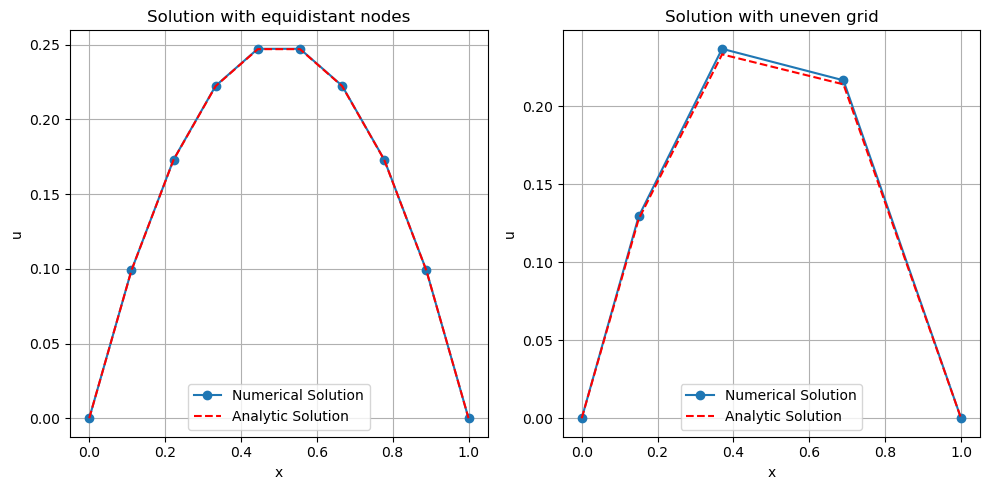

Stiffness matrix for plot on the right:
 A=
 [[ 1.          0.          0.          0.          0.        ]
 [-7.14166667 11.33545455 -4.00878788  0.          0.        ]
 [ 0.         -5.00878788  7.85045455 -2.57166667  0.        ]
 [ 0.          0.         -3.57166667  6.56080645 -2.67413978]
 [ 0.          0.          0.          0.          1.        ]]


In [5]:
#defining nonzero constants alpha, b and c
a, b, c = 1, 1, 1

#first set of nodes
Nodes1 = np.linspace(0, 1, 10)
U1, A1 = solver(f_func_1, Nodes1, a, b, c)  #assuming these return values you need

#second set of nodes
Nodes2 = np.array([0, 0.15, 0.37, 0.69, 1])
U2, A2 = solver(f_func_1, Nodes2, a, b, c)

#plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(Nodes1, U1, 'o-', label='Numerical Solution')
axs[0].plot(Nodes1, analytic_func_1(Nodes1), 'r--', label='Analytic Solution')
axs[0].set_title('Solution with equidistant nodes')
axs[0].set_xlabel('x')
axs[0].set_ylabel('u')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(Nodes2, U2, 'o-', label='Numerical Solution')
axs[1].plot(Nodes2, analytic_func_1(Nodes2), 'r--', label='Analytic Solution')
axs[1].set_title('Solution with uneven grid')
axs[1].set_xlabel('x')
axs[1].set_ylabel('u')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

#entire stiffness matrix
print("Stiffness matrix for plot on the right:\n A=\n", A2)

### Problem 2b)

In [6]:
def convergence_test(initial_steps, n, solver, f_func, U_exact): 
    
    errors_H1 = np.zeros(n)
    errors_L2 = np.zeros(n)
    hs = np.zeros(n)
    steps = initial_steps

    for i in range(n):
        h = 1/(steps)
        hs[i] = h
        Nodes = np.linspace(0, 1, steps+1)
        U, A = solver(f_func, Nodes, a, b, c)
        
        U_func = interp1d(Nodes,U)
        new_nodes = np.linspace(0,1,100000)
        U_new = U_func(new_nodes)
        U_ex = U_exact(new_nodes)
    
        errors_H1[i] = np.sqrt(simps(np.gradient(U_new-U_ex,new_nodes)**2,new_nodes) + simps((U_new-U_ex)**2,new_nodes))
        errors_L2[i] = np.sqrt(simps((U_new-U_ex)**2,new_nodes))
        steps *= 2  
    
    order_H1 = np.polyfit(np.log(hs),np.log(errors_H1),1)[0]
    order_L2 = np.polyfit(np.log(hs),np.log(errors_L2),1)[0]
    
    return hs, errors_H1, errors_L2, order_H1, order_L2  
    
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin-right:20px;"'), raw=True)

In [7]:
hs, errors_H1, errors_L2, order_H1, order_L2 = convergence_test(4,6,solver, f_func_1, analytic_func_1)

Rate_H1 = np.zeros(np.size(errors_H1))
Rate_H1[1:] = np.log10(errors_H1[1:] / errors_H1[:-1]) / np.log10(hs[1:] / hs[:-1])
df_H1 = pd.DataFrame(data={'h': hs, 'Error_H1': errors_H1 , 'Rate_H1': Rate_H1})

Rate_L2 = np.zeros(np.size(errors_L2))
Rate_L2[1:] = np.log10(errors_L2[1:] / errors_L2[:-1]) / np.log10(hs[1:] / hs[:-1])
df_L2 = pd.DataFrame(data={'h': hs, 'Error_L2': errors_L2 , 'Rate_L2': Rate_L2})

pd.options.display.float_format = '{:.8f}'.format

display_side_by_side(df_H1, df_L2)

,h,Error_H1,Rate_H1
0,0.25000000,0.14475223,0.00000000
1,0.12500000,0.07221125,1.00329010
2,0.06250000,0.03608000,1.00102416
3,0.03125000,0.01803175,1.00066025
4,0.01562500,0.00900979,1.00097384
5,0.00781250,0.00449908,1.00186263
,h,Error_L2,Rate_L2
0,0.25000000,0.01075026,0.00000000
1,0.12500000,0.00268020,2.00395721
2,0.06250000,0.00066959,2.00098606


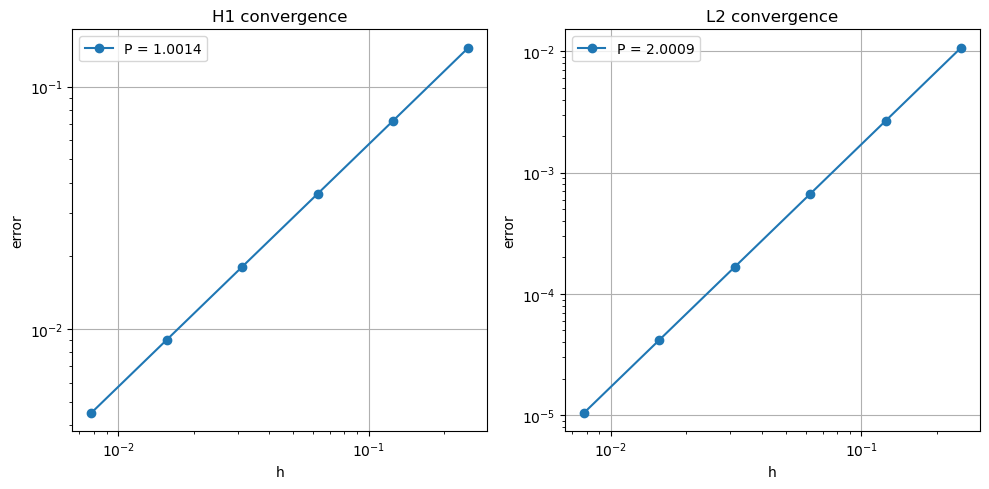

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns subplot

#H1 convergence plot
axs[0].loglog(hs, errors_H1, "o-", label=f"P = {round(order_H1,4)}")
axs[0].set_title("H1 convergence")
axs[0].set_xlabel('h')
axs[0].set_ylabel('error')
axs[0].legend()
axs[0].grid(True)

#L2 convergence plot
axs[1].loglog(hs, errors_L2, "o-", label=f"P = {round(order_L2,4)}")
axs[1].set_title("L2 convergence")
axs[1].set_xlabel('h')
axs[1].set_ylabel('error')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Problem 2d)

In [9]:
def w_1(x):
    return np.where(x <= np.sqrt(2)/2,
                    x / (np.sqrt(2)/2),
                    (1 - x) / (1 - np.sqrt(2)/2))

def f_func_w_1(x, a, b, c):
    return np.where(x <= np.sqrt(2)/2,
                    b*2/np.sqrt(2) + c*2*x/np.sqrt(2),
                    b*(-2-np.sqrt(2)) + (c*(1-x))/(1-np.sqrt(2)/2))    
    
def f_func_u_x(x,a,b,c):
    if x <= np.sqrt(2)/2:
        return a*(2/np.sqrt(2))
    else:
        return a*(-2-np.sqrt(2))
    
def w_2(x):
    return x-x**(3/4)
    
def f_func_w_2(x,a,b,c):
    return -a*(3/16)*x**(-5/4) + b*(1-(3/4)*x**(-1/4)) + c*(x-x**(3/4))

def F_func_w_2(x,a,b,c):
    return (3/4) * a * x**(-0.25) + b * (-x**0.75 + x) + c * (x**2 / 2 - (4/7) * x**1.75)

In [10]:
def solver_2(f_func,Nodes, a, b, c):
    
    H = Nodes[1:] - Nodes[:-1]
    Mi = len(Nodes)
    
    A = np.zeros((Mi, Mi))
    f = np.zeros(Mi)
    
    for i in range(1, Mi-1):
        A[i, i-1] = -a/H[i-1] - b/2 + c*H[i-1]/6
        A[i, i] = a*(1/H[i-1] + 1/H[i]) + c*(H[i-1]+H[i])/3
        A[i, i+1] = -a/H[i] + b/2 + c*H[i]/6
        
        f_1 = lambda x, i=i: phi(x, i, Nodes)*f_func(x, a, b, c) 
        f_2 = lambda x, i=i: phi_deriv(x, i, Nodes)*f_func_u_x(x,a,b,c)
        f[i] = quad(f_1, Nodes[i-1], Nodes[i+1])[0] + quad(f_2, Nodes[i-1], Nodes[i+1])[0]
        
        
       
    A[0, 0] = A[-1, -1] = 1
    f[0] = f[-1] = 0

    U = np.linalg.solve(A,f)
    
    return U, A

In [11]:
def solver_3(F_func,Nodes, a, b, c):
    
    H = Nodes[1:] - Nodes[:-1]
    Mi = len(Nodes)
    
    A = np.zeros((Mi, Mi))
    f = np.zeros(Mi)
    
    for i in range(1, Mi-1):
        A[i, i-1] = -a/H[i-1] - b/2 + c*H[i-1]/6
        A[i, i] = a*(1/H[i-1] + 1/H[i]) + c*(H[i-1]+H[i])/3
        A[i, i+1] = -a/H[i] + b/2 + c*H[i]/6
        
        phi_i = lambda x, i=i: -phi_deriv(x, i, Nodes)*F_func(x, a, b, c) 
        f[i] = quad(phi_i, Nodes[i-1], Nodes[i+1])[0]

       
    A[0, 0] = A[-1, -1] = 1
    f[0] = f[-1] = 0

    
    U = np.linalg.solve(A,f)
    
    return U,A

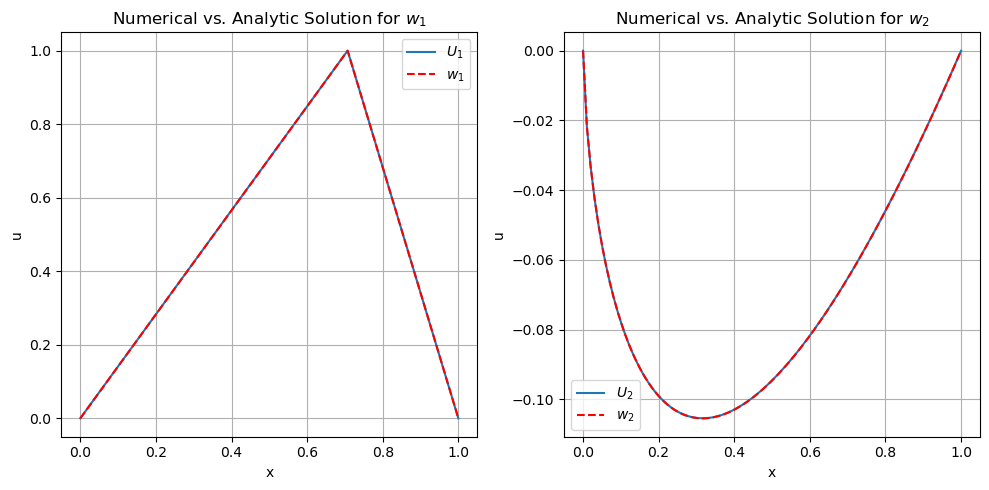

In [12]:
Nodes = np.linspace(0,1,100)
a, b, c = 1,1,1
U,A = solver_2(f_func_w_1,Nodes,a,b,c)
U2,A2 = solver_3(F_func_w_2,Nodes,a,b,c)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns for subplots

#first subplot with U and w_1
axs[0].plot(Nodes, U, label=r'$U_1$')
axs[0].plot(Nodes, w_1(Nodes), "r--", label=r"$w_1$")
axs[0].set_title(r'Numerical vs. Analytic Solution for $w_1$')
axs[0].set_xlabel('x')
axs[0].set_ylabel('u')
axs[0].legend()
axs[0].grid(True)

#second subplot with U2 and w_2
axs[1].plot(Nodes, U2, label=r'$U_2$')
axs[1].plot(Nodes, w_2(Nodes), "r--", label=r"$w_2$")
axs[1].set_title(r'Numerical vs. Analytic Solution for $w_2$')
axs[1].set_xlabel('x')
axs[1].set_ylabel('u')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

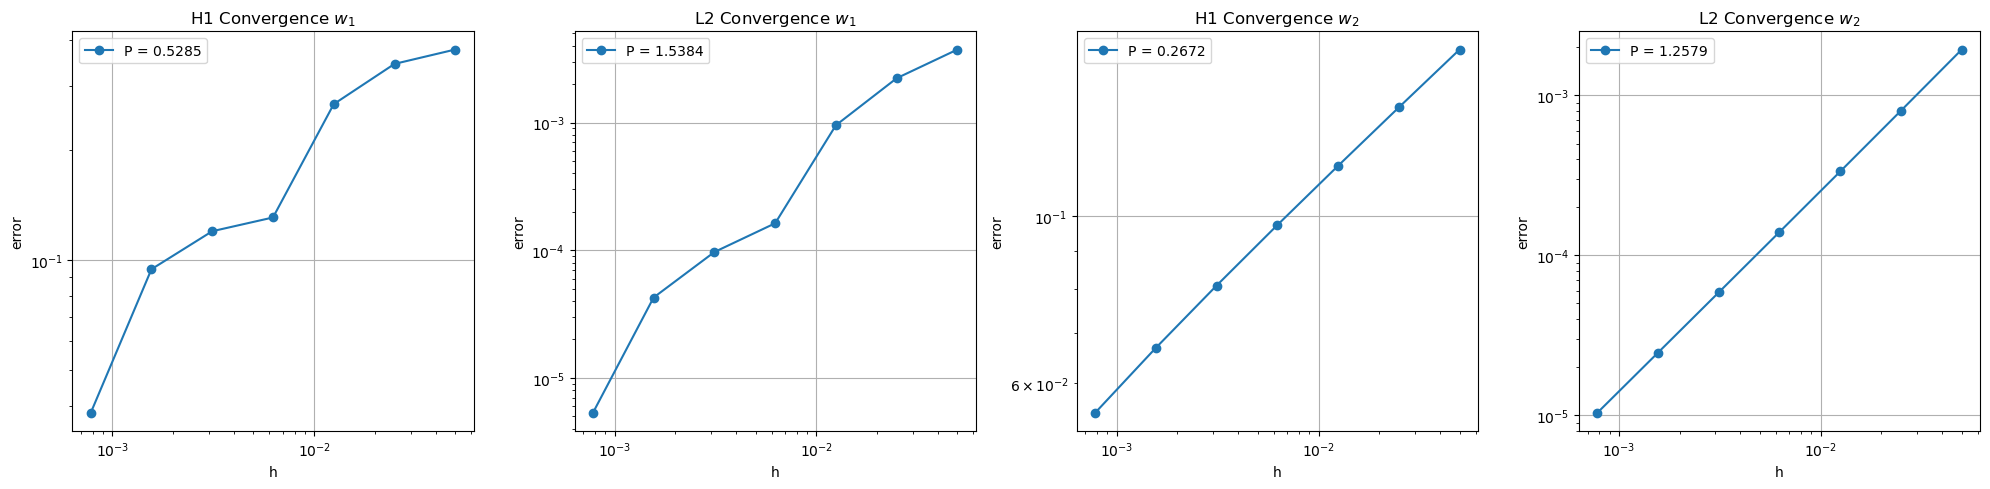

In [13]:
hs, errors_H1, errors_L2, order_H1, order_L2 = convergence_test(20,7,solver_2, f_func_w_1, w_1)
hs2, errors_H1_2, errors_L2_2, order_H1_2, order_L2_2 = convergence_test(20,7,solver_3, F_func_w_2, w_2)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 2 rows, 2 columns for subplots

#first subplot for errors_H1 from the first convergence test
axs[0].loglog(hs, errors_H1, "o-", label=f"P = {round(order_H1,4)}")
axs[0].set_title(r"H1 Convergence $w_1$")
axs[0].set_xlabel('h')
axs[0].set_ylabel('error')
axs[0].legend()
axs[0].grid(True)

#second subplot for errors_L2 from the first convergence test
axs[1].loglog(hs, errors_L2, "o-", label=f"P = {round(order_L2,4)}")
axs[1].set_title(r"L2 Convergence $w_1$")
axs[1].set_xlabel('h')
axs[1].set_ylabel('error')
axs[1].legend()
axs[1].grid(True)

#third subplot for errors_H1 from the second convergence test
axs[2].loglog(hs2, errors_H1_2, "o-", label=f"P = {round(order_H1_2,4)}")
axs[2].set_title(r"H1 Convergence $w_2$")
axs[2].set_xlabel('h')
axs[2].set_ylabel('error')
axs[2].legend()
axs[2].grid(True)

#fourth subplot for errors_L2 from the second convergence test
axs[3].loglog(hs2, errors_L2_2, "o-", label=f"P = {round(order_L2_2,4)}")
axs[3].set_title(r"L2 Convergence $w_2$")
axs[3].set_xlabel('h')
axs[3].set_ylabel('error')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()

### Problems 2e) and 2f)

In [14]:
def f_1(x,a,b,c):
    return x**(-2/5)

def f_2(x,a,b,c):
    return x**(-7/5)

def F_2(x,a,b,c):
    return -(5/2)*x**(-2/5)

In [15]:
all_errors_H1_refined = []
all_errors_L2_refined = []
M_values = [10,20,50,100]
rs = np.linspace(0.1,0.9,9)
a, b, c = 1, -70, 1

for M in M_values:
    Nodes_fine = np.linspace(0, 1, 10000)
    U_fine, A2 = solver(f_1, Nodes_fine, a, b, c)
    U_fine_func = interp1d(Nodes_fine, U_fine)

    Nodes_coarse = np.linspace(0, 1, M)
    U_coarse, A3 = solver(f_1, Nodes_coarse, a, b, c)  # Not directly used in the error calculations

    errors_H1_refined = []
    errors_L2_refined = []

    for r in rs:
        Nodes_refined = np.zeros(M + 1)
        for i in range(1, M + 1):
            Nodes_refined[i] = r ** (M - i)

        U_refined, A = solver(f_1, Nodes_refined, a, b, c)

        U_refined_func = interp1d(Nodes_refined, U_refined)
        new_nodes = np.linspace(0, 1, 100000)
        U_refined_new = U_refined_func(new_nodes)
        U_fine_new = U_fine_func(new_nodes)

        error_H1 = np.sqrt(simps(np.gradient(U_refined_new - U_fine_new, new_nodes) ** 2, new_nodes) + simps((U_refined_new - U_fine_new) ** 2, new_nodes))
        error_L2 = np.sqrt(simps((U_refined_new - U_fine_new) ** 2, new_nodes))

        errors_H1_refined.append(error_H1)
        errors_L2_refined.append(error_L2)

    all_errors_H1_refined.append(errors_H1_refined)
    all_errors_L2_refined.append(errors_L2_refined)

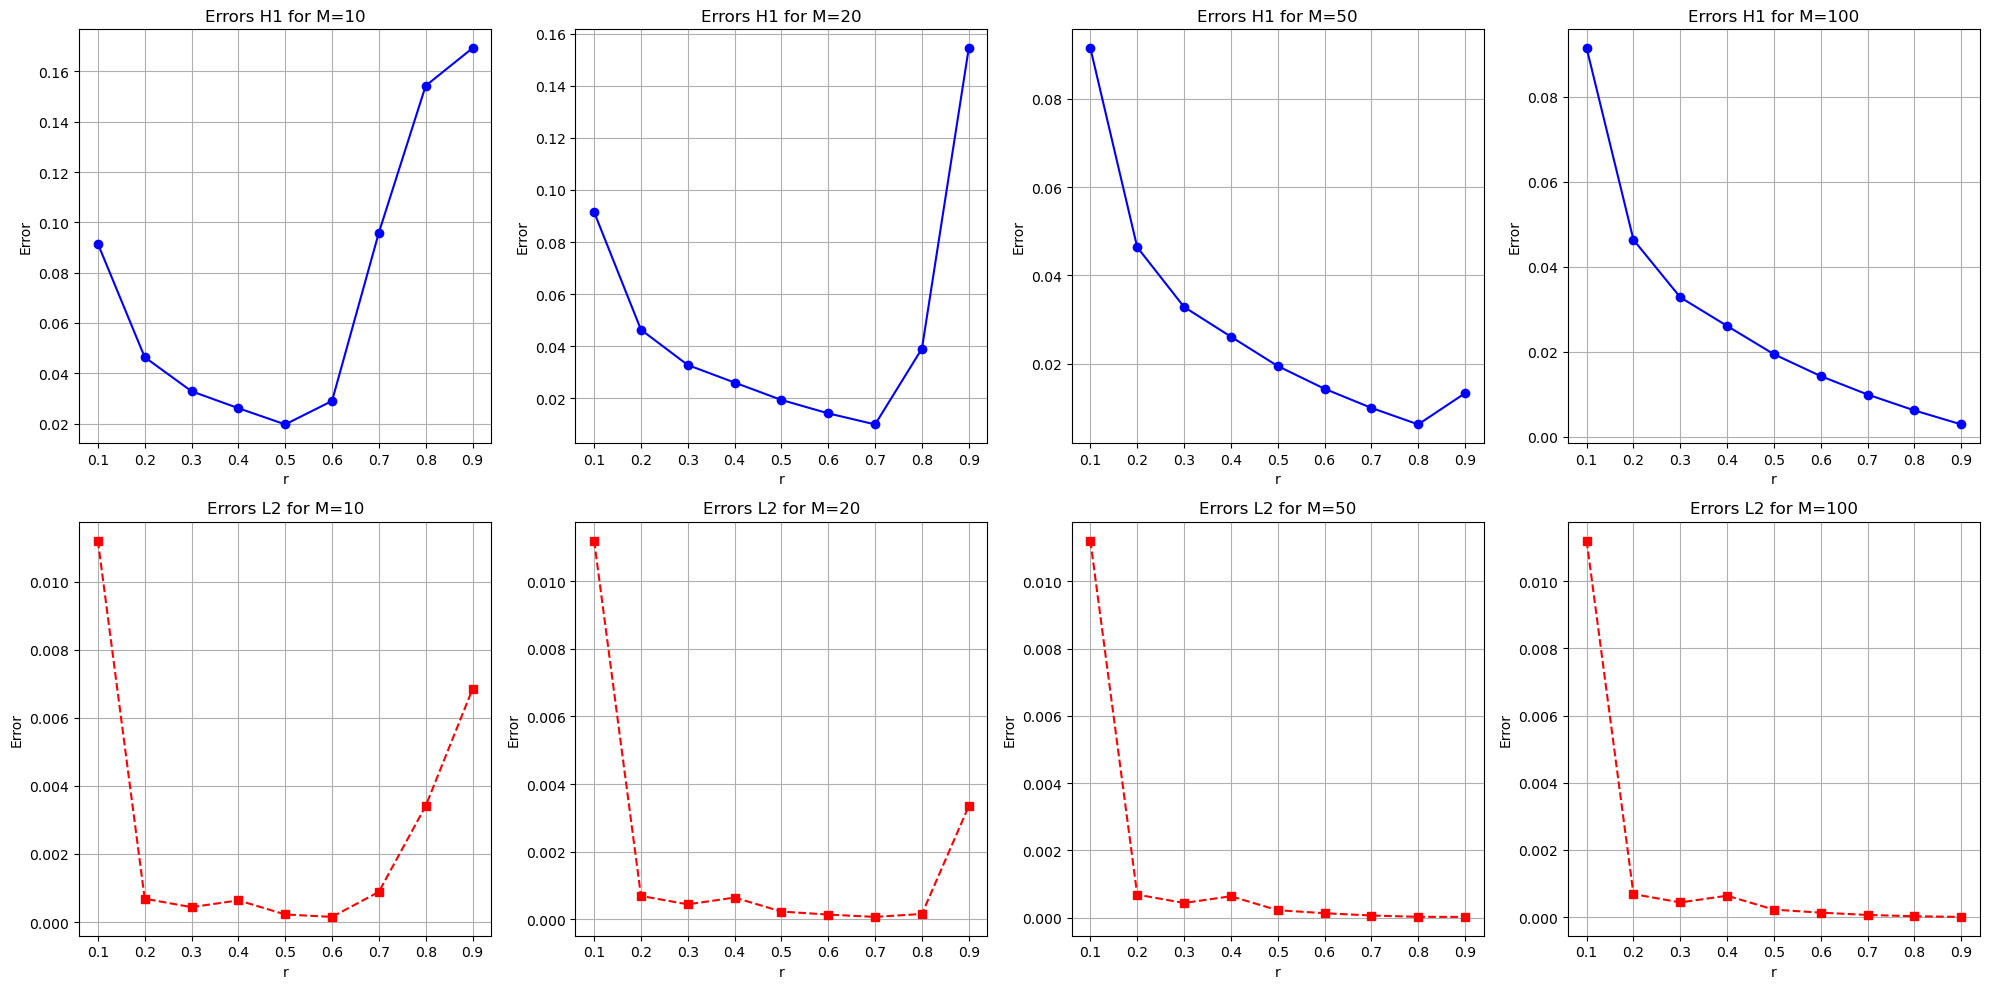

In [16]:
#plotting the errors for all M values
fig, axs = plt.subplots(2, len(M_values), figsize=(20, 10))

for i, M in enumerate(M_values):
    axs[0, i].plot(rs, all_errors_H1_refined[i], marker='o', linestyle='-', color='blue')
    axs[0, i].set_title(f'Errors H1 for M={M}')
    axs[0, i].set_xlabel('r')
    axs[0, i].set_ylabel('Error')
    axs[0, i].grid(True)

    axs[1, i].plot(rs, all_errors_L2_refined[i], marker='s', linestyle='--', color='red')
    axs[1, i].set_title(f'Errors L2 for M={M}')
    axs[1, i].set_xlabel('r')
    axs[1, i].set_ylabel('Error')
    axs[1, i].grid(True)

plt.tight_layout()
plt.show()

In [17]:
r_values = [0.5, 0.7, 0.8, 0.9]

#initialising lists to store errors
H1_errors = []
L2_errors = []

for i in range(len(M_values)):
    M = M_values[i]
    r = r_values[i]

    #nodes setup
    Nodes_refined = np.zeros(M+1)
    for j in range(1, M+1):
        Nodes_refined[j] = r**(M-j)
    
    Nodes_coarse = np.linspace(0, 1, M+1)
    Nodes_fine = np.linspace(0, 1, 10000)
    
    #solutions calculation
    U_coarse, _ = solver(f_1, Nodes_coarse, a, b, c)
    U_refined, _ = solver(f_1, Nodes_refined, a, b, c)
    U_fine, _ = solver(f_1, Nodes_fine, a, b, c)
    
    #interpolation for error calculation
    U_refined_func = interp1d(Nodes_refined, U_refined)
    U_coarse_func = interp1d(Nodes_coarse, U_coarse)
    U_fine_func = interp1d(Nodes_fine, U_fine)
    
    new_nodes = np.linspace(0, 1, 10000)
    
    #calculating new solutions for error analysis
    U_refined_new = U_refined_func(new_nodes)
    U_coarse_new = U_coarse_func(new_nodes)
    U_fine_new = U_fine_func(new_nodes)
    
    #error calculation
    errors_H1_coarse = np.sqrt(simps(np.gradient(U_coarse_new-U_fine_new, new_nodes)**2, new_nodes) + simps((U_coarse_new-U_fine_new)**2, new_nodes))
    errors_L2_coarse = np.sqrt(simps((U_coarse_new-U_fine_new)**2, new_nodes))
    
    errors_H1_refined = np.sqrt(simps(np.gradient(U_refined_new-U_fine_new, new_nodes)**2, new_nodes) + simps((U_refined_new-U_fine_new)**2, new_nodes))
    errors_L2_refined = np.sqrt(simps((U_refined_new-U_fine_new)**2, new_nodes))
    
    #storing errors in lists
    H1_errors.append(np.array([errors_H1_coarse, errors_H1_refined]))
    L2_errors.append(np.array([errors_L2_coarse, errors_L2_refined]))

H1_errors = np.array(H1_errors)
L2_errors = np.array(L2_errors)

In [18]:
H1_errors_coarse = H1_errors[:,0]   #example H1 coarse errors for each M
L2_errors_coarse = L2_errors[:,0]   #example L2 coarse errors for each M
H1_errors_refined = H1_errors[:,1]  #example H1 refined errors for each M
L2_errors_refined = L2_errors[:,1]  #example L2 refined errors for each M

#preparing the data dictionary for the DataFrame
data = {
    'Coarse': [],
    'Refined': []
}

#constructing the row labels and filling the data for each category
row_labels = []
for i in range(len(M_values)):
    row_labels.extend([f'H1 M={M_values[i]}, r={r_values[i]}', f'L2 M={M_values[i]},, r={r_values[i]}'])
    data['Coarse'].extend([H1_errors_coarse[i], L2_errors_coarse[i]])
    data['Refined'].extend([H1_errors_refined[i], L2_errors_refined[i]])

#creating the DataFrame
df = pd.DataFrame(data, index=row_labels)

styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "150%"),
                              ("color", 'black')])]

df = df.style.set_caption(r"Errors for $f_1$").set_table_styles(styles)

df

,Coarse,Refined
"H1 M=10, r=0.5",0.144858,0.019281
"L2 M=10,, r=0.5",0.003366,0.000222
"H1 M=20, r=0.7",0.108834,0.009657
"L2 M=20,, r=0.7",0.001301,0.000064
"H1 M=50, r=0.8",0.055006,0.005851
"L2 M=50,, r=0.8",0.000268,0.000025
"H1 M=100, r=0.9",0.028822,0.002557
"L2 M=100,, r=0.9",0.000071,0.000006


In [19]:
all_errors_H1_refined = []
all_errors_L2_refined = []
M_values = [10,20,50,100]
rs = np.linspace(0.1,0.9,9)
a, b, c = 1, -70, 1

for M in M_values:
    Nodes_fine = np.linspace(0, 1, 10000)
    U_fine, A2 = solver_3(F_2, Nodes_fine, a, b, c)
    U_fine_func = interp1d(Nodes_fine, U_fine)

    Nodes_coarse = np.linspace(0, 1, M)
    U_coarse, A3 = solver_3(F_2, Nodes_coarse, a, b, c)  # Not directly used in the error calculations

    errors_H1_refined = []
    errors_L2_refined = []

    for r in rs:
        Nodes_refined = np.zeros(M + 1)
        for i in range(1, M + 1):
            Nodes_refined[i] = r ** (M - i)

        U_refined, A = solver_3(F_2, Nodes_refined, a, b, c)

        U_refined_func = interp1d(Nodes_refined, U_refined)
        new_nodes = np.linspace(0, 1, 100000)
        U_refined_new = U_refined_func(new_nodes)
        U_fine_new = U_fine_func(new_nodes)

        error_H1 = np.sqrt(simps(np.gradient(U_refined_new - U_fine_new, new_nodes) ** 2, new_nodes) + simps((U_refined_new - U_fine_new) ** 2, new_nodes))
        error_L2 = np.sqrt(simps((U_refined_new - U_fine_new) ** 2, new_nodes))

        errors_H1_refined.append(error_H1)
        errors_L2_refined.append(error_L2)

    all_errors_H1_refined.append(errors_H1_refined)
    all_errors_L2_refined.append(errors_L2_refined)

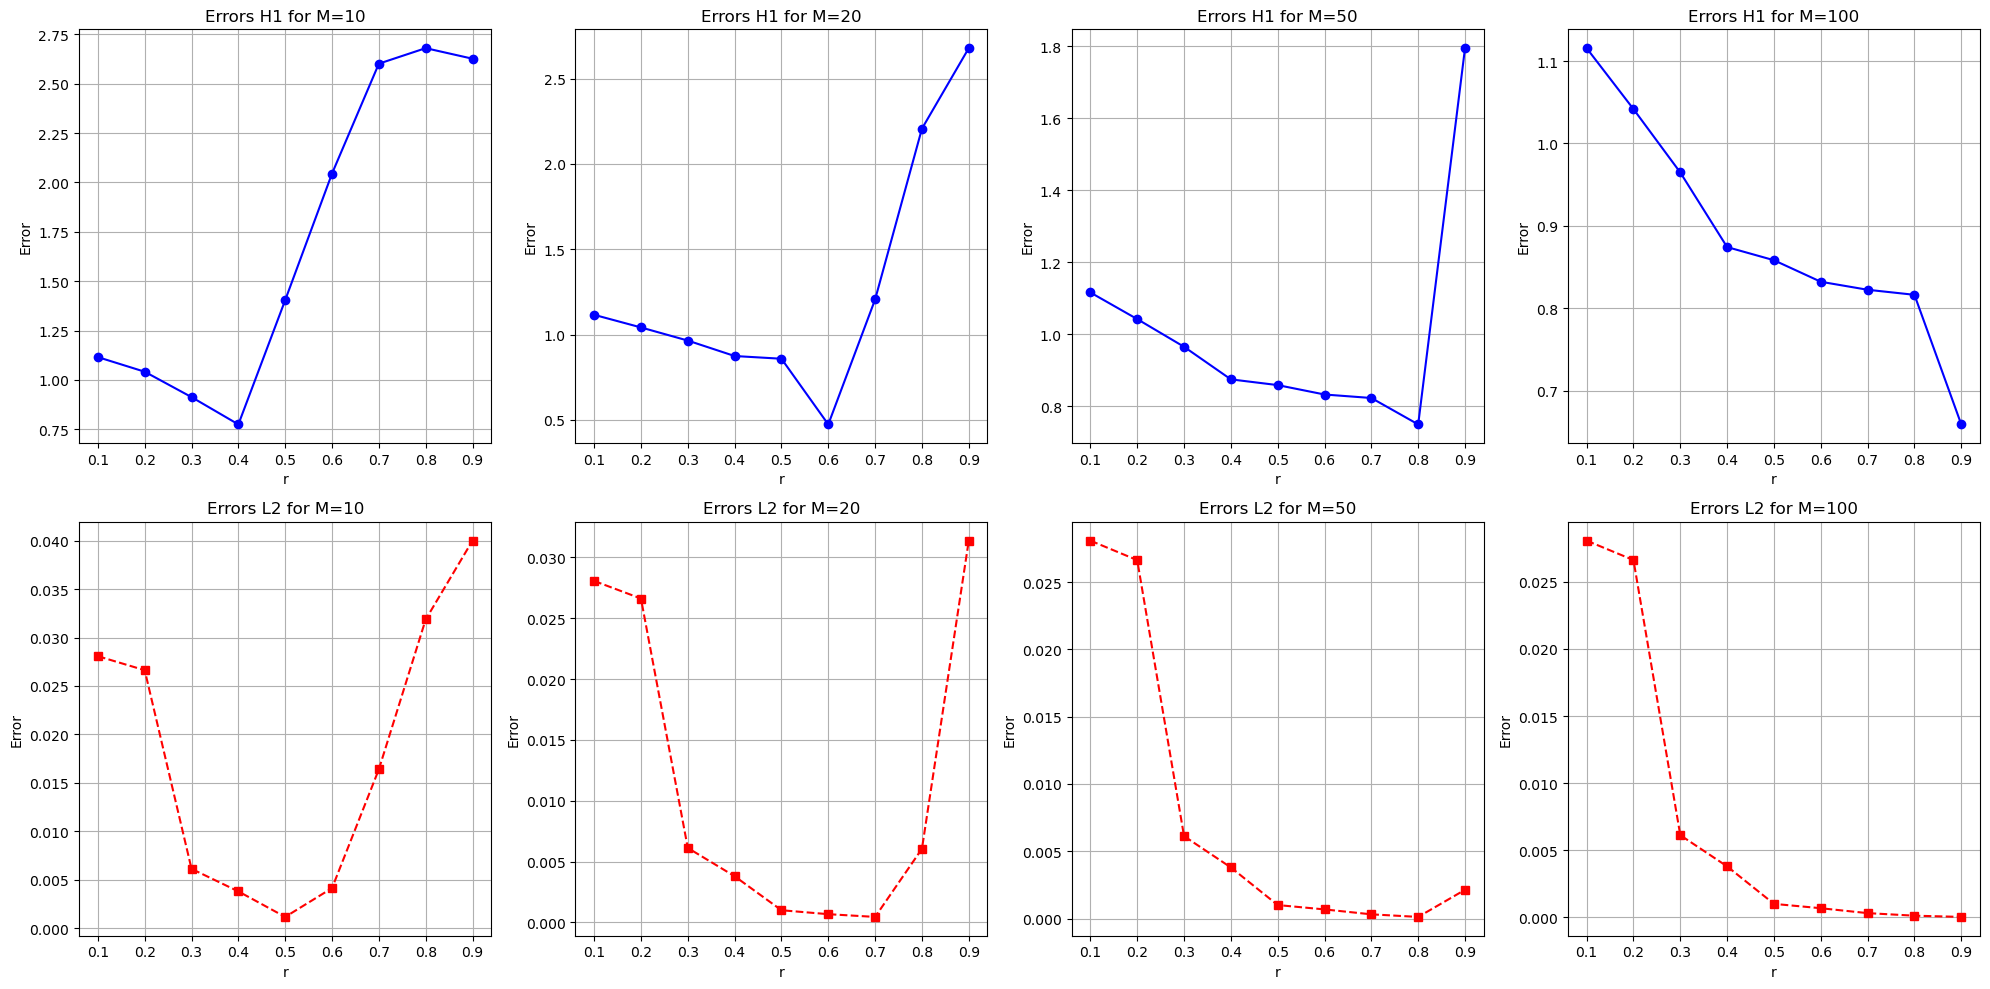

In [20]:
#plotting the errors for all M values
fig, axs = plt.subplots(2, len(M_values), figsize=(20, 10))

for i, M in enumerate(M_values):
    axs[0, i].plot(rs, all_errors_H1_refined[i], marker='o', linestyle='-', color='blue')
    axs[0, i].set_title(f'Errors H1 for M={M}')
    axs[0, i].set_xlabel('r')
    axs[0, i].set_ylabel('Error')
    axs[0, i].grid(True)

    axs[1, i].plot(rs, all_errors_L2_refined[i], marker='s', linestyle='--', color='red')
    axs[1, i].set_title(f'Errors L2 for M={M}')
    axs[1, i].set_xlabel('r')
    axs[1, i].set_ylabel('Error')
    axs[1, i].grid(True)

plt.tight_layout()
plt.show()

In [21]:
r_values = [0.4, 0.6, 0.8, 0.9]
M_values = [10, 20, 50, 100]

#initialising lists to store errors
H1_errors = []
L2_errors = []

for i in range(len(M_values)):
    M = M_values[i]
    r = r_values[i]

    #nodes setup
    Nodes_refined = np.zeros(M+1)
    for j in range(1, M+1):
        Nodes_refined[j] = r**(M-j)
    
    Nodes_coarse = np.linspace(0, 1, M+1)
    Nodes_fine = np.linspace(0, 1, 10000)
    
    #solution calculation
    U_coarse, _ = solver_3(F_2, Nodes_coarse, a, b, c)
    U_refined, _ = solver_3(F_2, Nodes_refined, a, b, c)
    U_fine, _ = solver_3(F_2, Nodes_fine, a, b, c)
    
    #interpolation for error calculation
    U_refined_func = interp1d(Nodes_refined, U_refined)
    U_coarse_func = interp1d(Nodes_coarse, U_coarse)
    U_fine_func = interp1d(Nodes_fine, U_fine)
    
    new_nodes = np.linspace(0, 1, 10000)
    
    #calculating new solutions for error analysis
    U_refined_new = U_refined_func(new_nodes)
    U_coarse_new = U_coarse_func(new_nodes)
    U_fine_new = U_fine_func(new_nodes)
    
    #error calculation
    errors_H1_coarse = np.sqrt(simps(np.gradient(U_coarse_new-U_fine_new, new_nodes)**2, new_nodes) + simps((U_coarse_new-U_fine_new)**2, new_nodes))
    errors_L2_coarse = np.sqrt(simps((U_coarse_new-U_fine_new)**2, new_nodes))
    
    errors_H1_refined = np.sqrt(simps(np.gradient(U_refined_new-U_fine_new, new_nodes)**2, new_nodes) + simps((U_refined_new-U_fine_new)**2, new_nodes))
    errors_L2_refined = np.sqrt(simps((U_refined_new-U_fine_new)**2, new_nodes))
    
    #storing errors in lists
    H1_errors.append(np.array([errors_H1_coarse, errors_H1_refined]))
    L2_errors.append(np.array([errors_L2_coarse, errors_L2_refined]))

H1_errors = np.array(H1_errors)
L2_errors = np.array(L2_errors)

In [22]:
H1_errors_coarse = H1_errors[:,0]   #example H1 coarse errors for each M
L2_errors_coarse = L2_errors[:,0]   #example L2 coarse errors for each M
H1_errors_refined = H1_errors[:,1]  #example H1 refined errors for each M
L2_errors_refined = L2_errors[:,1]  #example L2 refined errors for each M

M_values = [10, 20, 50, 100]
r_values = [0.4, 0.6, 0.8, 0.9]  #just for reference, as it's not used in the DataFrame based on the latest instructions

#preparing the data dictionary for the DataFrame
data = {
    'Coarse': [],
    'Refined': []
}

#constructing the row labels and filling the data for each category
row_labels = []
for i in range(len(M_values)):
    row_labels.extend([f'H1 M={M_values[i]}, r={r_values[i]}', f'L2 M={M_values[i]}, r={r_values[i]}'])
    data['Coarse'].extend([H1_errors_coarse[i], L2_errors_coarse[i]])
    data['Refined'].extend([H1_errors_refined[i], L2_errors_refined[i]])

#creating the DataFrame
df = pd.DataFrame(data, index=row_labels)

styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "150%"),
                              ("color", 'black')])]

df = df.style.set_caption(r"Errors for $f_2$").set_table_styles(styles)

#displaying the DataFrame
df

,Coarse,Refined
"H1 M=10, r=0.4",2.647061,0.564115
"L2 M=10, r=0.4",0.034751,0.003799
"H1 M=20, r=0.6",2.602543,0.177010
"L2 M=20, r=0.6",0.021170,0.000681
"H1 M=50, r=0.8",2.298950,0.066916
"L2 M=50, r=0.8",0.008674,0.000123
"H1 M=100, r=0.9",1.978961,0.025310
"L2 M=100, r=0.9",0.004003,0.000028


In [23]:
r = 0.8
M = 50
Nodes_refined = np.zeros(M+1)

for i in range(1,M+1):
    Nodes_refined[i] = r**(M-i)
    

Nodes_fine = np.linspace(0,1,10000)
a, b, c = 1, -70, 1
Nodes_coarse = np.linspace(0,1,M+1)

U_coarse, A3 = solver(f_1,Nodes_coarse,a,b,c)
U_refined, A = solver(f_1,Nodes_refined,a,b,c)
U_fine, A2 = solver(f_1,Nodes_fine,a,b,c)

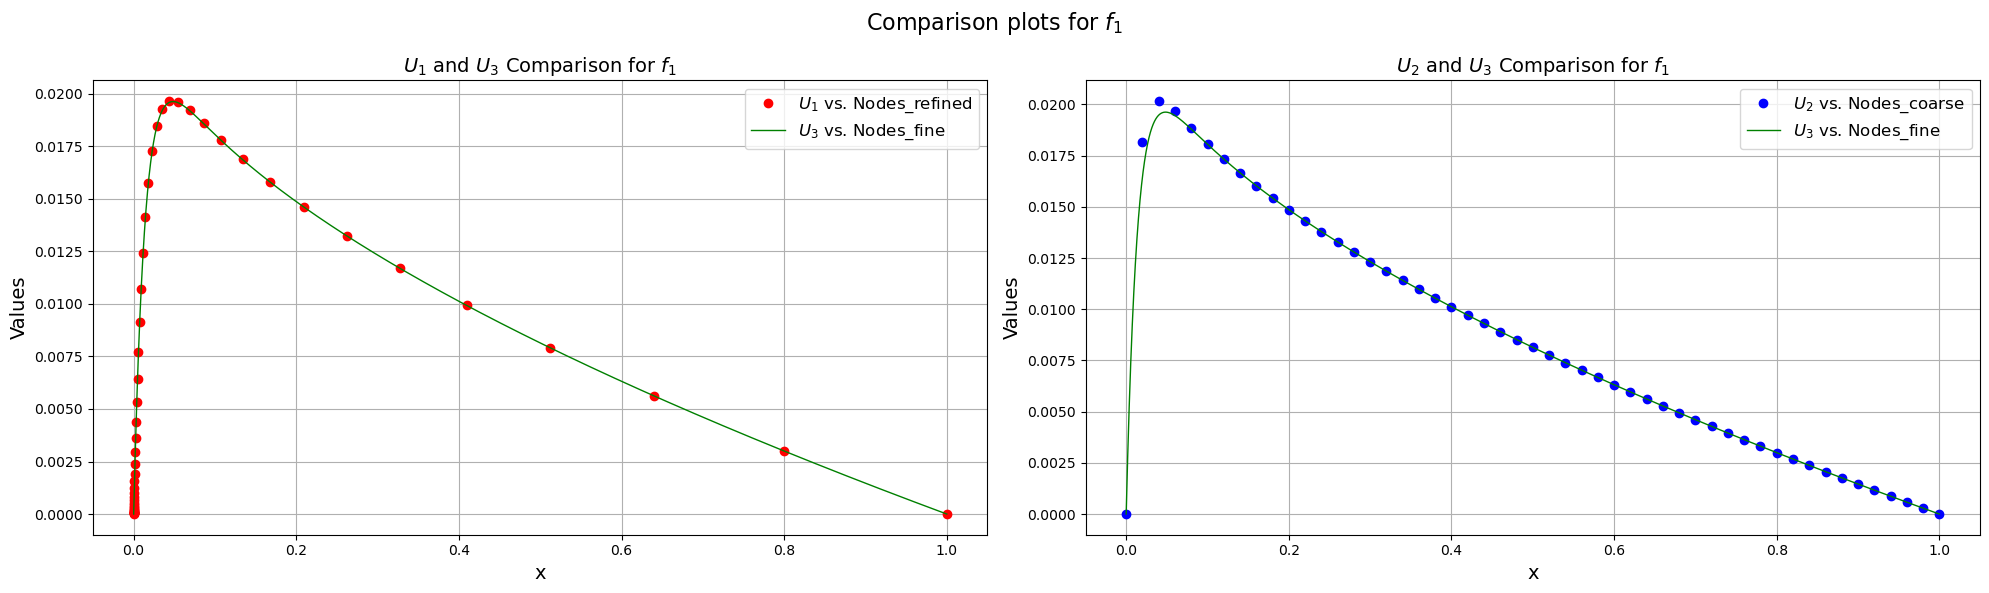

In [24]:
plt.figure(figsize=(20, 6))

#plotting U1 and U3 to the left
plt.subplot(1, 2, 1)  
plt.plot(Nodes_refined, U_refined, 'ro', label=r'$U_1$ vs. Nodes_refined', linewidth=1)
plt.plot(Nodes_fine, U_fine, 'g-', label=r'$U_3$ vs. Nodes_fine', markersize=1, linewidth=1)
plt.xlabel('x', fontsize=14) 
plt.ylabel('Values', fontsize=14)
plt.title(r'$U_1$ and $U_3$ Comparison for $f_1$', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

#plotting U2 and U3 to the right
plt.subplot(1, 2, 2) 
plt.plot(Nodes_coarse, U_coarse, 'bo', label=r'$U_2$ vs. Nodes_coarse', linewidth=1)  #changed marker to 'o'
plt.plot(Nodes_fine, U_fine, 'g-', label=r'$U_3$ vs. Nodes_fine', markersize=1, linewidth=1)
plt.xlabel('x', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title(r'$U_2$ and $U_3$ Comparison for $f_1$', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle(r"Comparison plots for $f_1$", fontsize = 16)
plt.tight_layout() 
plt.show()

In [25]:
r = 0.8
M = 50
Nodes_refined = np.zeros(M+1)

for i in range(1,M+1):
    Nodes_refined[i] = r**(M-i)
    
Nodes_fine = np.linspace(0,1,10000)
a, b, c = 1, -70, 1
Nodes_coarse = np.linspace(0,1,M+1)

U_coarse, A3 = solver_3(F_2,Nodes_coarse,a,b,c)
U_refined, A = solver_3(F_2,Nodes_refined,a,b,c)
U_fine, A2 = solver_3(F_2,Nodes_fine,a,b,c)

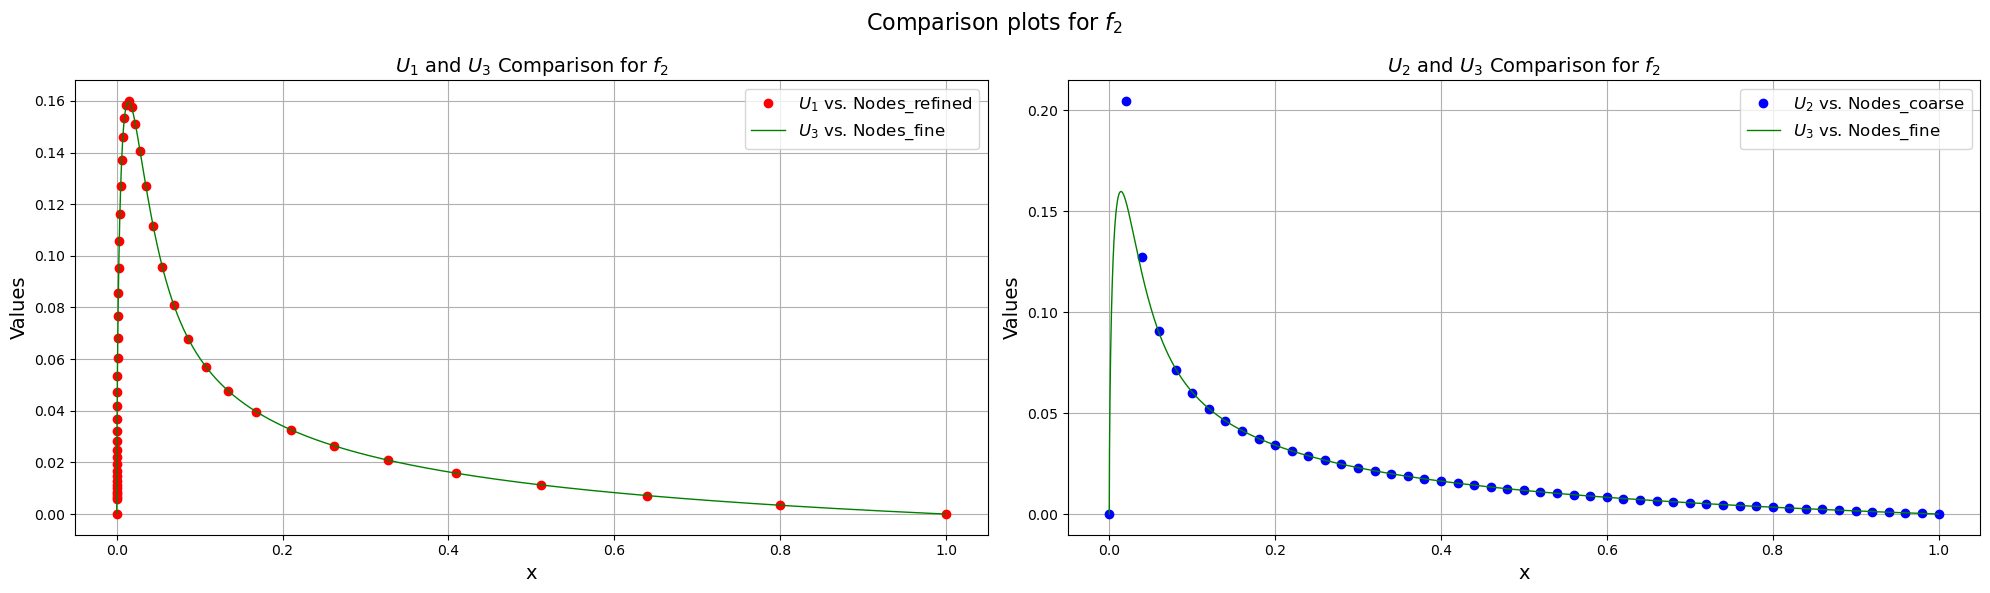

In [26]:
plt.figure(figsize=(20, 6))  #increasing figure size for two plots side by side

#plotting U1 and U3 to the left
plt.subplot(1, 2, 1) 
plt.plot(Nodes_refined, U_refined, 'ro', label=r'$U_1$ vs. Nodes_refined', linewidth=1)
plt.plot(Nodes_fine, U_fine, 'g-', label=r'$U_3$ vs. Nodes_fine', markersize=1, linewidth=1)
plt.xlabel('x', fontsize=14) 
plt.ylabel('Values', fontsize=14)
plt.title(r'$U_1$ and $U_3$ Comparison for $f_2$', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

#plotting U2 and U3 to the right
plt.subplot(1, 2, 2) 
plt.plot(Nodes_coarse, U_coarse, 'bo', label=r'$U_2$ vs. Nodes_coarse', linewidth=1) 
plt.plot(Nodes_fine, U_fine, 'g-', label=r'$U_3$ vs. Nodes_fine', markersize=1, linewidth=1)
plt.xlabel('x', fontsize=14)  
plt.ylabel('Values', fontsize=14)
plt.title(r'$U_2$ and $U_3$ Comparison for $f_2$', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle(r"Comparison plots for $f_2$", fontsize = 16)
plt.tight_layout()  
plt.show()

In [6]:
IRR = 0.1467
c = 2*30.375
F = 450
P = 435
sol = c*(1-(1+IRR)**(-4))/IRR + F/(1+IRR)**4 - P

print(sol)

-0.13235899601852452
